In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [6]:
#Pour l'architecture que j'ai entraîné sur Stim NB Lum Norm, j'ai pris le code suivant : 

def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(input_latent=256):
    input_img = tf.keras.Input(shape=(150, 150, 1))
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 256, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 256, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(x)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150,150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()
    return model

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
dataset_white = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['CAUCASIENS'],
    target_size=(150, 150),
    batch_size=16, 
    class_mode='input',
    color_mode='grayscale')
dataset_east_asian = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['ASIATIQUES'],
    target_size=(150, 150),
    batch_size=16,
    class_mode='input',
    color_mode='grayscale')
dataset_mixed = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary',
    color_mode='grayscale')

Found 56 images belonging to 1 classes.
Found 56 images belonging to 1 classes.
Found 112 images belonging to 2 classes.


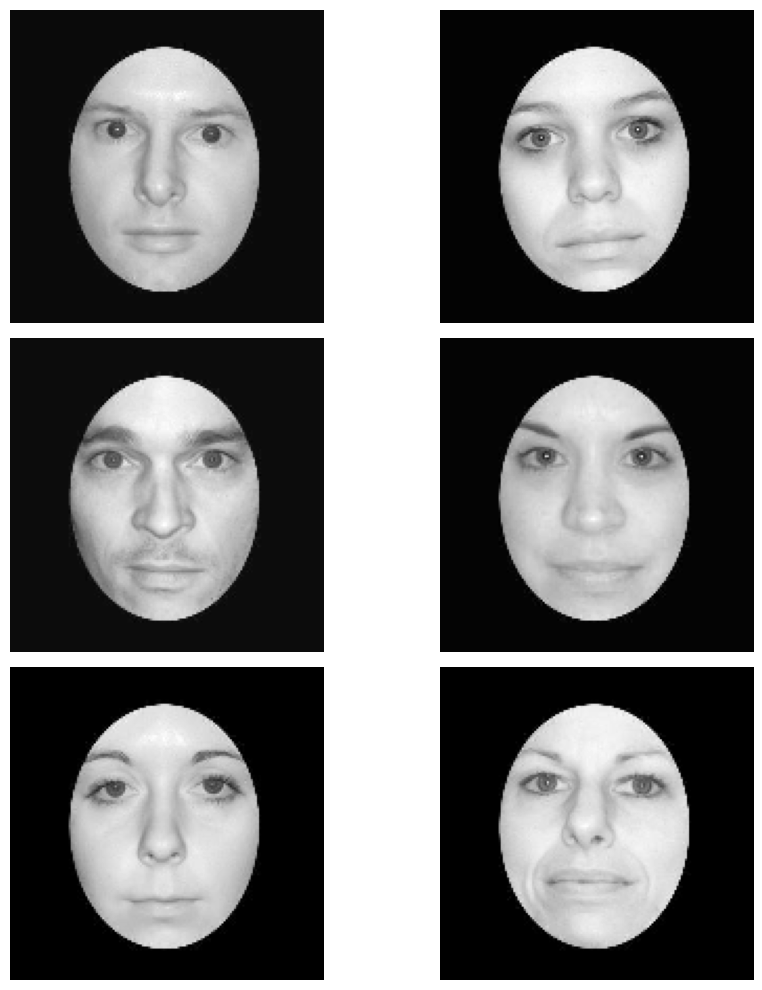

In [8]:
# Récupérer un lot d'images du générateur
batch = next(dataset_white)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 3
num_cols = 2

plt.figure(figsize=(10, 10))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
shape = (150, 150,1)
input_latent = 128 #nombre de dimensions de l'espace latent, celui dont on veut qu'il modélise le face space de Tim Valentine donc
model = create_resnet_autoencoder()
chekpoint_path = 'stim_autoencoder.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 75, 75, 32)   288         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 75, 75, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [30]:
history = model.fit(x=dataset_east_asian, epochs=5000, batch_size=32, validation_data=dataset_east_asian)

Epoch 1/5000
4/4 [==============================] - 1s 101ms/step - loss: 0.0031 - mae: 0.0314 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 2/5000
4/4 [==============================] - 0s 62ms/step - loss: 0.0031 - mae: 0.0315 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 3/5000
4/4 [==============================] - 0s 62ms/step - loss: 0.0030 - mae: 0.0313 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 4/5000
4/4 [==============================] - 0s 61ms/step - loss: 0.0030 - mae: 0.0315 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 5/5000
4/4 [==============================] - 0s 61ms/step - loss: 0.0031 - mae: 0.0314 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 6/5000
4/4 [==============================] - 0s 59ms/step - loss: 0.0030 - mae: 0.0312 - val_loss: 0.0034 - val_mae: 0.0339
Epoch 7/5000
4/4 [==============================] - 0s 67ms/step - loss: 0.0030 - mae: 0.0313 - val_loss: 0.0034 - val_mae: 0.0338
Epoch 8/5000
4/4 [==============================] - 0s 61ms/step - loss: 0.0030 - 

In [31]:
get_latent2 = keras.Model(inputs=model.input, outputs=model.get_layer('dense_1').output)

In [36]:
get_latent

In [13]:
X_train, y_train = next(dataset_east_asian)
X_train1, y_train = next(dataset_east_asian)
X_train2, _ = next(dataset_east_asian)
X_train3, _ = next(dataset_east_asian)
east_asian = np.concatenate((X_train,X_train1,X_train2,X_train3), axis=0)
X_train, y_train = next(dataset_white)
X_train1, y_train = next(dataset_white)
X_train2, _ = next(dataset_white)
X_train3, _ = next(dataset_white)
white = np.concatenate((X_train,X_train1,X_train2,X_train3), axis=0)

2/2 [==============================] - 0s 147ms/step


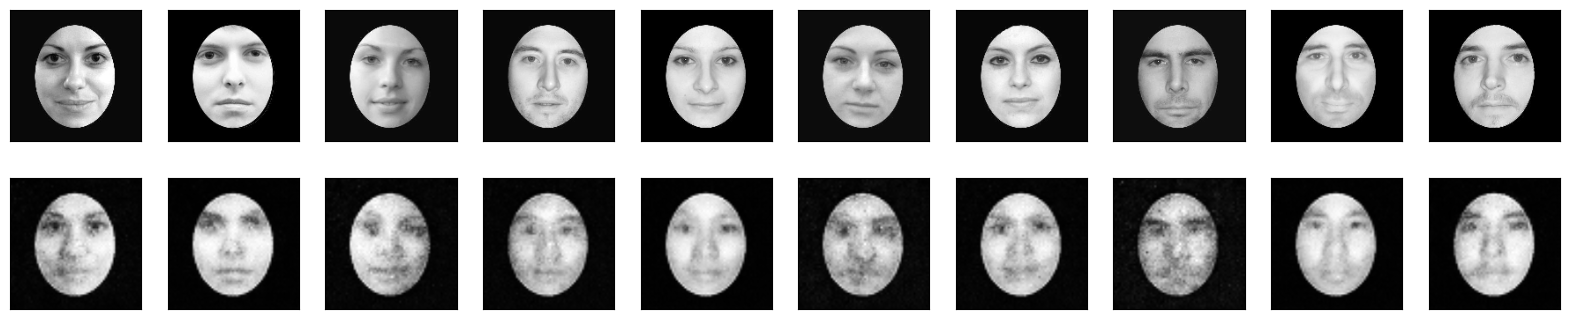

In [32]:
# Reconstruction des images à partir des représentations latentes
reconstructed_white = model.predict(white)

# Affichage des images originales et reconstruites
import matplotlib.pyplot as plt

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(white[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_white[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


2/2 [==============================] - 0s 148ms/step


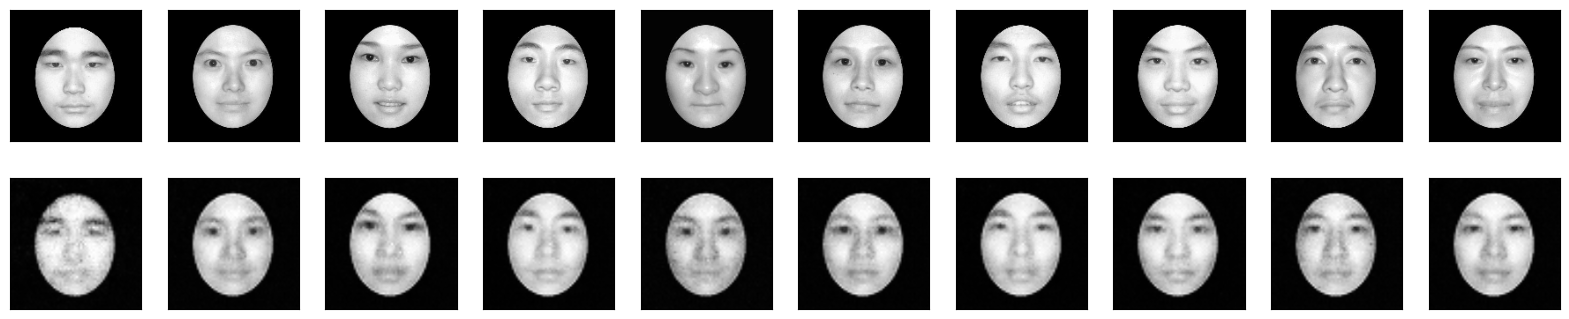

In [33]:
# Reconstruction des images à partir des représentations latentes
reconstructed_east_asian = model.predict(east_asian)

# Affichage des images originales et reconstruites
import matplotlib.pyplot as plt

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(east_asian[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_east_asian[i].reshape(150,150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [16]:
flat_recon_east_asian = reconstructed_east_asian.reshape(56, -1)
flat_recon_white = reconstructed_white.reshape(56, -1)
flat_east_asian = east_asian.reshape(56, -1)
flat_white = white.reshape(56, -1)

# Calculer les normes de chaque ensemble de données
norms_recon_east_asian = np.linalg.norm(flat_recon_east_asian, axis=1, keepdims=True)
norms_east_asian = np.linalg.norm(flat_east_asian, axis=1, keepdims=True)
norms_recon_white = np.linalg.norm(flat_recon_white, axis=1, keepdims=True)
norms_white = np.linalg.norm(flat_white, axis=1, keepdims=True)

# Calculer les produits internes entre chaque paire de vecteurs
dot_products_white = np.dot(flat_white, flat_recon_white.T)
dot_products_east_asian = np.dot(flat_east_asian, flat_recon_east_asian.T)

# Calculer les similarités cosinus
similarities_white = dot_products_white / (norms_recon_white * norms_white.T)
similarities_east_asian = dot_products_east_asian / (norms_recon_east_asian * norms_east_asian.T)


In [22]:
def cosine_similarity(vec_a, vec_b):
    # Aplatir les vecteurs à une dimension
    flat_vec_a = vec_a.flatten()
    flat_vec_b = vec_b.flatten()
    
    # Calculer le produit scalaire (dot product) des vecteurs
    dot_product = np.dot(flat_vec_a, flat_vec_b)
    
    # Calculer la norme de chaque vecteur
    norm_a = np.linalg.norm(flat_vec_a)
    norm_b = np.linalg.norm(flat_vec_b)
    
    # Calculer la similarité cosinus
    cosine_similarity = dot_product / (norm_a * norm_b)
    
    return cosine_similarity

# Exemple d'utilisation
vec_a = np.random.rand(56, 150, 150)
vec_b = np.random.rand(56, 150, 150)

similarity = cosine_similarity(east_asian, reconstructed_east_asian)
print(f"La similarité cosinus entre les deux vecteurs est: {similarity}")

La similarité cosinus entre les deux vecteurs est: 0.9878481030464172


In [25]:
similarity = mean_cosine_similarity(white, reconstructed_white)
print(f"La similarité cosinus entre les deux vecteurs est: {similarity}")

La similarité cosinus entre les deux vecteurs est: 0.9953182935714722


In [34]:
import numpy as np

def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

def mean_cosine_similarity(matrix_a, matrix_b):
    similarities = []
    for vec_a, vec_b in zip(matrix_a, matrix_b):
        flat_vec_a = vec_a.flatten()
        flat_vec_b = vec_b.flatten()
        similarity = cosine_similarity(flat_vec_a, flat_vec_b)
        similarities.append(similarity)
    return np.mean(similarities)

# Exemple d'utilisation
vec_a = np.random.rand(56, 150, 150)
vec_b = np.random.rand(56, 150, 150)

mean_similarity = mean_cosine_similarity(east_asian, reconstructed_east_asian)
print(f"La moyenne des similarités cosinus est: {mean_similarity}")

La moyenne des similarités cosinus est: 0.995016872882843


In [35]:
mean_similarity = mean_cosine_similarity(white, reconstructed_white)
print(f"La moyenne des similarités cosinus est: {mean_similarity}")

La moyenne des similarités cosinus est: 0.9907682538032532


4/4 [==============================] - 0s 40ms/step


In [38]:
import numpy as np
from scipy.linalg import sqrtm



# Supposons que `data` est votre ensemble de données d'entrée
# et `model` est votre modèle d'auto-encodeur pré-entraîné.

# Obtenir les représentations latentes pour votre ensemble de données
latent_representations = get_latent.predict(dataset_mixed)
latent_representations2 = get_latent2.predict(dataset_mixed)

# Calculer la moyenne et la matrice de covariance des représentations latentes
mean1 = np.mean(latent_representations, axis=0)
cov1 = np.cov(latent_representations, rowvar=False)
mean2 = np.mean(latent_representations2, axis=0)
cov2 = np.cov(latent_representations2, rowvar=False)

# mean1 est le vecteur de moyenne de l'espace latent
# cov1 est la matrice de covariance de l'espace latent

def bhattacharyya_coefficient(mean1, cov1, mean2, cov2):
    # Calcul de la moyenne des matrices de covariance
    cov_mean = (cov1 + cov2) / 2
    
    # Calcul de la racine carrée de la matrice de covariance moyenne
    cov_mean_sqrt = sqrtm(cov_mean)
    
    # Vérification que la racine carrée est une matrice réelle
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real
    
    # Calcul du terme exponentiel
    diff_mean = mean1 - mean2
    exponent_term = -0.25 * np.dot(diff_mean.T, np.dot(np.linalg.inv(cov_mean), diff_mean))
    
    # Calcul du coefficient
    coefficient = np.exp(exponent_term) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2) * np.linalg.det(cov_mean_sqrt)**2)
    
    return coefficient


bc = bhattacharyya_coefficient(mean1, cov1, mean2, cov2)
print(f"Le coefficient de Bhattacharyya est: {bc}")

LinAlgError: Singular matrix

In [41]:
import numpy as np
from scipy.linalg import sqrtm
from tensorflow import keras

# Ajoutons une fonction pour régulariser la matrice de covariance
def regularized_covariance(matrix, alpha=1e-3):
    """Ajoute une petite valeur alpha à la diagonale de la matrice de covariance."""
    cov = np.cov(matrix, rowvar=False)
    if matrix.shape[0] > 1:  # Plus d'une donnée pour éviter la division par zéro
        cov += np.eye(cov.shape[0]) * alpha
    return cov

# Supposons que `dataset_mixed` est votre ensemble de données d'entrée
# et que `get_latent` et `get_latent2` sont des modèles Keras qui retournent
# les représentations latentes de deux auto-encodeurs différents.

# Obtenir les représentations latentes pour votre ensemble de données
latent_representations = get_latent.predict(dataset_white)
latent_representations2 = get_latent2.predict(dataset_east_asian)

# Calculer la moyenne et la matrice de covariance des représentations latentes
mean1 = np.mean(latent_representations, axis=0)
cov1 = regularized_covariance(latent_representations)
mean2 = np.mean(latent_representations2, axis=0)
cov2 = regularized_covariance(latent_representations2)

def bhattacharyya_coefficient(mean1, cov1, mean2, cov2):
    # Calcul de la moyenne des matrices de covariance
    cov_mean = (cov1 + cov2) / 2
    
    # Calcul de la racine carrée de la matrice de covariance moyenne
    cov_mean_sqrt = sqrtm(cov_mean)
    
    # Vérification que la racine carrée est une matrice réelle
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real
    
    # Calcul du terme exponentiel
    diff_mean = mean1 - mean2
    exponent_term = -0.25 * np.dot(diff_mean.T, np.dot(np.linalg.inv(cov_mean), diff_mean))
    
    # Calcul du coefficient
    coefficient = np.exp(exponent_term) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2) * np.power(np.linalg.det(cov_mean_sqrt), 2))
    
    return coefficient

# Calcul du coefficient de Bhattacharyya
bc = bhattacharyya_coefficient(mean1, cov1, mean2, cov2)
print(f"Le coefficient de Bhattacharyya est: {bc}")

4/4 [==============================] - 0s 32ms/step
Le coefficient de Bhattacharyya est: inf


C:\Users\Guilem\AppData\Local\Temp\ipykernel_19940\1042327796.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  coefficient = np.exp(exponent_term) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2) * np.power(np.linalg.det(cov_mean_sqrt), 2))
